In [1]:
from api import inoreader_api, inoreader_scraping
import json
import pandas as pd
import re
import random
import pickle

# Scrape feeds starting from a concrete moment and store them in a file.

In [2]:
start_time = 1508112001
feed = 'user/-/label/arXiv'
file_name = 'articles_raw.json'

number_scraped = inoreader_scraping.scrape(feed, start_time, file_name)
print(number_scraped)


Requesting: stream/contents/user/-/label/arXiv
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=68YS8nbhWbrT
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=4dKhxlSNYfoE
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=qj8QIRUjKJLo
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=MEP9UCLOxOsH
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=HjRKRZLEjJEL
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=wfiu9iKHyik4
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=ouUHa1WU3xCS
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=HFmEpa7mFWFU
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=kgWdtaNBXmiN
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=gaLFspY2a0yu
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=CyHgeK7YYS61
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=Crz0TJOHsmjb
200 OK

Requesting: stream/contents/user/-/label/arXiv?c=kYgZu0R2QOZr
200 OK

Requesting: stream/contents/user/-

# Load the feeds from disk.

In [3]:
f = open(file_name, 'r')
json_string = f.read()
f.close

json_object = json.loads(json_string)
all_articles = json_object['all_articles']

In [4]:
def get_abstract_string(abs_dict):
    abs_string = abs_dict['content']
    abs_string = re.search('<p>(.*)</p>', abs_string, flags=re.DOTALL)
    return abs_string.group(1)

In [5]:
def get_canonical_string(canonical_list):
    url_dict = canonical_list[0]
    url = url_dict['href']
    return url

# Create preprocessed and cleaned DataFrame.

In [6]:
all_articles_pd = pd.DataFrame(all_articles)
all_articles_pd = all_articles_pd[['canonical', 'author', 'categories', 'published', 'title', 'summary']]

for i in range(len(all_articles_pd)):
    all_articles_pd['summary'][i] = get_abstract_string(all_articles_pd['summary'][i])
    all_articles_pd['canonical'][i] = get_canonical_string(all_articles_pd['canonical'][i])
    
all_articles_pd['read'] = False
all_articles_pd['liked'] = False

for i in range(len(all_articles_pd)):
    if 'user/1005689817/state/com.google/read' in all_articles_pd['categories'][i]:
        all_articles_pd['read'][i] = True
    if 'user/1005689817/state/com.google/like' in all_articles_pd['categories'][i]:
        all_articles_pd['liked'][i] = True

del all_articles_pd['categories']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [7]:
#all_articles_pd

,canonical,author,published,title,summary,read,liked
0,http://arxiv.org/abs/1712.04473,V.I. Avrutskiy,1513228697,Enhancing approximation abilities of neural ne...,Method for increasing precision of feedforward...,True,False
1,http://arxiv.org/abs/1712.04602,"David M. Schwartz, O. Ozan Koyluoglu",1513228697,On the organization of grid and place cells: N...,Place cells in the hippocampus are active when...,True,False
2,http://arxiv.org/abs/1712.04604,"Chase Gaudet, Anthony Maida",1513228697,Deep Quaternion Networks. (arXiv:1712.04604v1 ...,The field of deep learning has seen significan...,True,False
3,http://arxiv.org/abs/1410.5610,Gabriele Scheler,1513228697,Logarithmic distributions prove that intrinsic...,"In this paper, we present data for the lognorm...",True,False
4,http://arxiv.org/abs/1708.07120,"Leslie N. Smith, Nicholay Topin",1513228697,Super-Convergence: Very Fast Training of Resid...,"In this paper, we show a phenomenon, which we ...",True,False
5,http://arxiv.org/abs/1710.08961,"Milad Makkie, Heng Huang, Yu Zhao, Athanasios ...",1513228697,Fast and Scalable Distributed Deep Convolution...,"In recent years, analyzing task-based fMRI (tf...",True,False
6,http://arxiv.org/abs/1711.01577,"Zhen He, Shaobing Gao, Liang Xiao, Daxue Liu, ...",1513228697,"Wider and Deeper, Cheaper and Faster: Tensoriz...",Long Short-Term Memory (LSTM) is a popular app...,True,True
7,http://arxiv.org/abs/1712.04443,"Bo Wu, Wen-Huang Cheng, Yongdong Zhang, Qiushi...",1513228697,Sequential Prediction of Social Media Populari...,Prediction of popularity has profound impact f...,True,True
8,http://arxiv.org/abs/1712.04596,"Son-Il Kwak, Oh-Chol Gwon, Chung-Jin Kwak",1513228697,"Consideration on Example 2 of ""An Algorithm of...","In this paper, we will show that (1) the resul...",True,False
9,http://arxiv.org/abs/1712.04603,"Jinyoung Choi, Beom-Jin Lee, Byoung-Tak Zhang",1513228697,Multi-focus Attention Network for Efficient De...,Deep reinforcement learning (DRL) has shown in...,True,False


In [8]:
tagged_articles_pd = all_articles_pd[all_articles_pd['read'] == True]

with open('old_articles.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    old_tagged_articles_pd = pickle.load(f)
    
tagged_articles_pd = pd.concat([tagged_articles_pd, old_tagged_articles_pd])

In [9]:
tagged_articles_unique_pd = tagged_articles_pd.sort_values(by=['canonical', 'liked'], ascending=False).reset_index(drop=True)
to_drop = tagged_articles_unique_pd.duplicated(subset = ['canonical'], keep='first')
to_drop = list(to_drop[to_drop == False].index.values)

tagged_articles_unique_pd = tagged_articles_unique_pd[tagged_articles_unique_pd.index.isin(to_drop)]

In [10]:
print(len(tagged_articles_pd))
print(len(tagged_articles_unique_pd))

1912
1774


In [11]:
X_ = list(tagged_articles_unique_pd['author']+' '+tagged_articles_unique_pd['title']+' '+tagged_articles_unique_pd['summary'])
y_ = list(tagged_articles_unique_pd['liked'])

In [12]:
index_shuffled = [i for i in range(len(X_))]
random.shuffle(index_shuffled)
X = []
y = []
for i in index_shuffled:
    X.append(X_[i])
    y.append(y_[i])

# SVC

In [102]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit


model_nb_tfidf = Pipeline([
    ("tfidf_vectorizer", TfidfVectorizer()),\
    ("nb", BernoulliNB())
])

limit = int(0.8*len(X))

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_nb_tfidf.fit(X_train, y_train)

y_predicted = model_nb_tfidf.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.89014084507042257, 0.94187779433681074)

In [104]:
y_predicted_proba = model_nb_tfidf.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.15)
y_predicted = (y_predicted_proba[:,1] > 0.15)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*50.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

y_predicted_proba[0:20]

0.89014084507 0.941877794337 0 355
0.0 % -  0


Rejected good ones:  39 / 39
Accepted wrong ones: 0 / 316


Rejected wrong ones:  316 / 316
Accepted good ones: 0 / 39


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


array([[  1.00000000e+00,   1.23385799e-33],
       [  1.00000000e+00,   2.24531875e-27],
       [  1.00000000e+00,   1.16339240e-30],
       [  1.00000000e+00,   6.82093895e-31],
       [  1.00000000e+00,   1.33855535e-29],
       [  1.00000000e+00,   2.45462188e-29],
       [  1.00000000e+00,   2.15653753e-32],
       [  1.00000000e+00,   3.13746960e-25],
       [  1.00000000e+00,   3.02504633e-21],
       [  1.00000000e+00,   3.15016559e-26],
       [  1.00000000e+00,   5.67328754e-32],
       [  1.00000000e+00,   1.00764249e-28],
       [  1.00000000e+00,   1.69188829e-33],
       [  1.00000000e+00,   2.89010293e-29],
       [  1.00000000e+00,   4.89600216e-22],
       [  1.00000000e+00,   7.09399248e-31],
       [  1.00000000e+00,   1.15695625e-33],
       [  1.00000000e+00,   5.94481389e-24],
       [  1.00000000e+00,   3.46267587e-26],
       [  1.00000000e+00,   6.10186982e-29]])

In [105]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

model_svc = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ("svc", SVC(kernel='linear', probability=True, class_weight = 'balanced'))
    #("svc", SVC(kernel='linear', probability=True))
])

limit = int(0.8*len(X))

X_train = X[:limit]
X_test = X[limit:]

y_train = y[:limit]
y_test = y[limit:]

model_svc.fit(X_train, y_train)

y_predicted = model_svc.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
acc, f1

(0.86760563380281686, 0.87340695188344464)

In [106]:
y_predicted_proba = model_svc.predict_proba(X_test)
#y_predicted = (y_predicted_proba[:,1] > 0.15)
y_predicted = (y_predicted_proba[:,1] > 0.15)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*50.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

y_predicted_proba[0:20]

0.738028169014 0.696346720293 94 355
26.4788732394 % -  13


Rejected good ones:  19 / 39
Accepted wrong ones: 74 / 316


Rejected wrong ones:  242 / 316
Accepted good ones: 20 / 39


array([[ 0.88608648,  0.11391352],
       [ 0.6190953 ,  0.3809047 ],
       [ 0.91971446,  0.08028554],
       [ 0.9192349 ,  0.0807651 ],
       [ 0.88096707,  0.11903293],
       [ 0.91636619,  0.08363381],
       [ 0.77910433,  0.22089567],
       [ 0.81164515,  0.18835485],
       [ 0.86768114,  0.13231886],
       [ 0.62544273,  0.37455727],
       [ 0.88682178,  0.11317822],
       [ 0.91336447,  0.08663553],
       [ 0.86770304,  0.13229696],
       [ 0.74785928,  0.25214072],
       [ 0.85589464,  0.14410536],
       [ 0.90750392,  0.09249608],
       [ 0.9592856 ,  0.0407144 ],
       [ 0.81381899,  0.18618101],
       [ 0.88892076,  0.11107924],
       [ 0.66749375,  0.33250625]])

In [108]:
import pickle

models_data = {
    'svc' : model_svc
}

pickle.dump(models_data,open('rss_models.pickle', "wb" ), protocol=2 )


In [38]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.models import Sequential
from keras.layers import (Input, Embedding, SimpleRNN, Dense, Activation, TimeDistributed, Bidirectional, LSTM, GaussianNoise)
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import plot_model #Local

Using TensorFlow backend.


In [43]:
DATASETS_DIR = '../ml-research/datasets/'
GLOVE_DIR = DATASETS_DIR+'glove.6B/'
embeddings_file = os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')

# Word embeddings' constraints
MAX_NB_WORDS = 20000  # Number of most common words for tokenizer
EMBEDDING_DIM = 300   # Embeddings dimensionality

In [44]:
# Tokenizing and creating word index

additional_words = ['unk', 'num']

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X+additional_words)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# inversing the word_index.
index_word = dict((k,v) for v,k in word_index.items())

# example
print(word_index['adversarial'])
print(word_index['unk'])

Found 21599 unique tokens.
134
21598


In [41]:
import models.embedding_matrix as embedding

embedding_matrix = embedding.create_embedding_matrix(embeddings_file, MAX_NB_WORDS, EMBEDDING_DIM, word_index.items())

Indexing word vectors.
Found 400000 word vectors.
Creating Word Embeddings matrix...
Word Embeddings matrix was successfuly created.


In [45]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import (Input, Embedding, SimpleRNN, Dense, Activation, TimeDistributed, Bidirectional,
                          LSTM, GaussianNoise,Conv1D, MaxPooling1D, Flatten, Dropout)
from keras.optimizers import SGD, RMSprop

from keras.models import Model

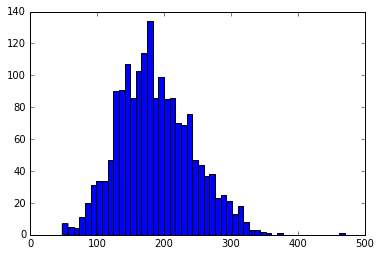

In [52]:
import matplotlib.pyplot as plt

X_sequences = tokenizer.texts_to_sequences(X)
X_sequences_len = []
for item in X_sequences:
    X_sequences_len.append(
                            min( len(item), 1000
                               ))
    
X_sequences_padded = pad_sequences(X_sequences, maxlen=hyperparameters['max_seq_len'])

plt.hist(X_sequences_len, 50)
plt.show()

In [53]:
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y)

y_num = label_encoder.transform(y)
y_matrix = to_categorical(y_num,hyperparameters['nclasses'])

In [54]:
hyperparameters = {
    'conv_units': 128,
    'hidden_units_1': 64,
    'hidden_units_2': 32,
    'dropout': 0.5,
    'pooling' : 5,
    'gauss_stddev' : 0.001,
    'epochs' : 10,
    'folds' : 5,
    'nclasses' : 2,
    'max_seq_len' : 300,
    'learning_rate' : 0.01,
    'stopwords' : True
}

In [68]:

(len(y)-sum(y))/sum(y)

6.8149779735682818

In [84]:
from sklearn.model_selection import KFold
import numpy as np
from keras import backend as K
import utils.evaluation as evaluation
from keras import metrics


class_weight = {0 : 1.,
    1: (len(y)-sum(y))/sum(y)}

acc_list = []
f1_list = []
cm_summed = np.zeros((2,2))
kf = KFold(n_splits=5, shuffle = True)
for train_index, test_index in kf.split(X_sequences):
    
    X_sequences_padded = pad_sequences(X_sequences, maxlen=hyperparameters['max_seq_len'])

    num_words = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=hyperparameters['max_seq_len'],
                                trainable=False)

    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(hyperparameters['max_seq_len'],), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    #x = GaussianNoise(hyperparameters['gauss_stddev'])(embedded_sequences)
    x = embedded_sequences
    x = Conv1D(hyperparameters['conv_units'], 7, activation='relu')(x)
    x = MaxPooling1D(7)(x)

    x = Flatten()(x)
    x = Dense(hyperparameters['hidden_units_1'], activation='relu')(x)
    x = Dropout(hyperparameters['dropout'])(x)
    x = Dense(hyperparameters['hidden_units_2'], activation='relu')(x)
    preds = Dense(hyperparameters['nclasses'], activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[metrics.categorical_accuracy])

    
    X_train, X_test = X_sequences_padded[train_index], X_sequences_padded[test_index]
    y_train, y_test = y_matrix[train_index], y_matrix[test_index]

    # train
    model.fit(X_train, y_train,
              batch_size=128,
              epochs=hyperparameters['epochs'],
              class_weight=class_weight,
              validation_data=(X_test, y_test))

    # run
    ground_truth = y_test.argmax(1)
    predictions = [list(map(lambda x: x, model.predict_on_batch(np.asarray([x])).argmax(1)))[0] \
            for x in X_test]
    
    
    acc = evaluation.accuracy(ground_truth, predictions)
    f1 = evaluation.eval_f1_score(ground_truth, predictions)    
    cm = evaluation.cm_matrix(ground_truth, predictions)
    acc_list.append(acc)
    f1_list.append(f1)
    cm_summed = cm_summed + cm
    
    break
    #del model
    K.clear_session()
    
print(np.asarray(acc).mean(), np.asarray(f1).mean())
print(cm_summed)

Train on 1419 samples, validate on 355 samples
Epoch 1/10
1419/1419 [==============================] - 18s - loss: 1.4142 - categorical_accuracy: 0.6054 - val_loss: 0.7382 - val_categorical_accuracy: 0.3408
Epoch 2/10
1419/1419 [==============================] - 16s - loss: 1.2767 - categorical_accuracy: 0.5011 - val_loss: 0.6192 - val_categorical_accuracy: 0.8085
Epoch 3/10
1419/1419 [==============================] - 15s - loss: 1.2189 - categorical_accuracy: 0.5906 - val_loss: 0.6442 - val_categorical_accuracy: 0.5634
Epoch 4/10
1419/1419 [==============================] - 15s - loss: 1.1668 - categorical_accuracy: 0.5088 - val_loss: 0.6841 - val_categorical_accuracy: 0.5549
Epoch 5/10
1419/1419 [==============================] - 15s - loss: 1.1697 - categorical_accuracy: 0.4884 - val_loss: 0.6501 - val_categorical_accuracy: 0.6225
Epoch 6/10
1419/1419 [==============================] - 24s - loss: 1.0957 - categorical_accuracy: 0.6364 - val_loss: 0.6530 - val_categorical_accuracy: 

In [95]:
ground_truth = y_test.argmax(1)
predictions = [list(map(lambda x: x, model.predict_on_batch(np.asarray([x]))))[0] \
        for x in X_test]

In [99]:
y_predicted_proba_np = np.asarray(predictions)
#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.15)

acc = accuracy_score(y_predicted, ground_truth)
f1 = f1_score(y_predicted, ground_truth, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*30.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != ground_truth) & (y_predicted == False)]), "/", sum(ground_truth))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != ground_truth) & (y_predicted == True)]), "/", len(ground_truth)-sum(ground_truth))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == ground_truth) & (y_predicted == False)]), "/", len(ground_truth)-sum(ground_truth))
print("Accepted good ones:", len(X_test_df[(y_predicted == ground_truth) & (y_predicted == True)]), "/", sum(ground_truth))

0.405633802817 0.334486765302 238 355
67.0422535211 % -  20


Rejected good ones:  8 / 43
Accepted wrong ones: 203 / 312


Rejected wrong ones:  109 / 312
Accepted good ones: 35 / 43


# Old stuff

In [ ]:
import numpy as np

# evaluate
y_predicted = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x])).argmax(1)))[0] \
               for x in x_test]
y_test = y[limit:]
y_test = to_categorical(y_test,2)
y_test = y_test.argmax(1)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted))

X_test_df = pd.DataFrame(X_test)
print("Total good ones:", sum(y_test))
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (np.asarray(y_predicted) == 0)]))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (np.asarray(y_predicted) == 1)]))



In [ ]:
y_predicted_proba = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x]))))[0] \
               for x in x_test]
y_predicted_proba_np = np.asarray(y_predicted_proba)
#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.2)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*30.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

In [ ]:

reload(runner)
# Padding sequences
x_train = pad_sequences(sequences_train, maxlen=hyperparameters['max_seq_len'])
x_test = pad_sequences(sequences_test, maxlen=hyperparameters['max_seq_len'])

dataset = x_train, y_train, x_test, y_test, embedding_matrix


In [ ]:

result_cnn, model_cnn = runner.build_train_run(dataset, le, hyperparameters_cnn, save=False, return_model=True)

In [ ]:
# evaluate
import numpy as np
y_predicted = [list(map(lambda x: x, model_cnn.predict_on_batch(np.asarray([x])).argmax(1)))[0] \
               for x in x_test]
y_test = y[limit:]
y_test = to_categorical(y_test,hyperparameters['nclasses'])
y_test = y_test.argmax(1)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted))

X_test_df = pd.DataFrame(X_test)
print("Total good ones:", sum(y_test))
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (np.asarray(y_predicted) == 0)]))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (np.asarray(y_predicted) == 1)]))


In [ ]:
y_predicted_proba = [list(map(lambda x: x, model_cnn.predict_on_batch(np.asarray([x]))))[0] \
               for x in x_test]
y_predicted_proba_np = np.asarray(y_predicted_proba)

#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.0005)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*30.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

y_predicted_proba[0:20]

In [ ]:
y_predicted_proba = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x]))))[0] \
               for x in x_test]
y_predicted_proba_np = np.asarray(y_predicted_proba)

y_predicted_proba[0:20]


In [ ]:
y_predicted_proba = [list(map(lambda x: x, model_lstm.predict_on_batch(np.asarray([x]))))[0] \
               for x in x_test]
y_predicted_proba_np = np.asarray(y_predicted_proba)
#y_predicted = (y_predicted_proba_np[:,1] > 0.001)
y_predicted = (y_predicted_proba_np[:,1] > 0.2)

acc = accuracy_score(y_predicted, y_test)
f1 = f1_score(y_predicted, y_test, average='weighted')
print(acc, f1, sum(y_predicted), len(y_predicted))
print(sum(y_predicted)/len(y_predicted)*100.0,"% - ", int(sum(y_predicted)/len(y_predicted)*30.0))
print("\n")
X_test_df = pd.DataFrame(X_test)
print("Rejected good ones: ", len(X_test_df[(y_predicted != y_test) & (y_predicted == False)]), "/", sum(y_test))
print("Accepted wrong ones:", len(X_test_df[(y_predicted != y_test) & (y_predicted == True)]), "/", len(y_test)-sum(y_test))
print("\n")
print("Rejected wrong ones: ", len(X_test_df[(y_predicted == y_test) & (y_predicted == False)]), "/", len(y_test)-sum(y_test))
print("Accepted good ones:", len(X_test_df[(y_predicted == y_test) & (y_predicted == True)]), "/", sum(y_test))

In [ ]:
y_test[0:20]